## 1. FRAMING THE PROBLEM

__AKIV Cars Machine Learning Algorithm__

AKIV Cars is a used-car dealership. Before buying any car to resell or selling to customers looking for used cars, AKIV wants to use their ML algorithm to predict the true value of a car (market price), as well as how long it will take to sell the car. AKIV will input the chosen explanatory variables (brand, type, gearbox, power, etc.) and extract from the algorithm the predicted market price and # of days to sell car.

## Initialization

In [277]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import statsmodels.api as sm
from scipy import stats

# Packages
from datetime import datetime
from pandas.plotting import scatter_matrix
from matplotlib.cbook import boxplot_stats 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from keras.layers.advanced_activations import LeakyReLU
from scipy.stats import reciprocal


# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Model evaluation und visualisation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

# Hyperparameter optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# to make this notebook's output stable across runs
np.random.seed(24)

2.1.0
2.2.4-tf


## 2. GETTING THE DATA

In [366]:
#Loading autos.csv file
autos = pd.read_csv("autos.csv", encoding="ISO-8859–1")

In [367]:
pd.set_option('display.max_rows', 10)

## 3. CLEANING & MANIPULATING THE DATA

In [368]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

Some columns have missing values and since they have "object" as data type, they will have to be removed as we will not focus on estimating the missing categorical values to fill in the blanks.

In [369]:
autos = autos.dropna()
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260956 entries, 3 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          260956 non-null  object
 1   name                 260956 non-null  object
 2   seller               260956 non-null  object
 3   offerType            260956 non-null  object
 4   price                260956 non-null  int64 
 5   abtest               260956 non-null  object
 6   vehicleType          260956 non-null  object
 7   yearOfRegistration   260956 non-null  int64 
 8   gearbox              260956 non-null  object
 9   powerPS              260956 non-null  int64 
 10  model                260956 non-null  object
 11  kilometer            260956 non-null  int64 
 12  monthOfRegistration  260956 non-null  int64 
 13  fuelType             260956 non-null  object
 14  brand                260956 non-null  object
 15  notRepairedDamage    260956 non-nu

Some columns are not relevant such as: name, abtest, monthOfRegistration, nrOfPictures, and postalCode, therefore we shall remove them.

In [370]:
autos = autos.drop(["name", "abtest", "monthOfRegistration", "nrOfPictures", "postalCode"], axis=1)
autos.head()

,dateCrawled,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,lastSeen
3,2016-03-17 16:54:04,privat,Angebot,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,privat,Angebot,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,privat,Angebot,650,limousine,1995,manuell,102,3er,150000,benzin,bmw,ja,2016-04-04 00:00:00,2016-04-06 19:17:07
6,2016-04-01 20:48:51,privat,Angebot,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot,nein,2016-04-01 00:00:00,2016-04-05 18:18:39
7,2016-03-21 18:54:38,privat,Angebot,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen,nein,2016-03-21 00:00:00,2016-03-25 16:47:58


In [371]:
# Select duplicate rows except first occurrence based on all columns
duplicateRowsAutos = autos[autos.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsAutos)

Duplicate Rows except first occurrence based on all columns are :
                dateCrawled  seller offerType  price vehicleType  \
156458  2016-03-07 12:00:46  privat   Angebot  10000       kombi   
179448  2016-03-08 18:42:48  privat   Angebot   1799       coupe   
242556  2016-03-28 00:56:10  privat   Angebot   1000  kleinwagen   
270719  2016-04-03 09:01:15  privat   Angebot   4699       coupe   
341474  2016-03-18 18:46:15  privat   Angebot   1999       kombi   

        yearOfRegistration    gearbox  powerPS   model  kilometer fuelType  \
156458                2013    manuell      184    golf      60000   diesel   
179448                1999  automatik      193     clk      20000   benzin   
242556                2002    manuell       83  andere     150000   benzin   
270719                2003  automatik      218     clk     125000   benzin   
341474                2001    manuell      131  passat     150000   diesel   

                brand notRepairedDamage          dateCre

In [372]:
autos = autos.drop_duplicates(keep='last')

In [373]:
autos.info() #new variable after duplicate rows were deleted

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260951 entries, 3 to 371527
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   dateCrawled         260951 non-null  object
 1   seller              260951 non-null  object
 2   offerType           260951 non-null  object
 3   price               260951 non-null  int64 
 4   vehicleType         260951 non-null  object
 5   yearOfRegistration  260951 non-null  int64 
 6   gearbox             260951 non-null  object
 7   powerPS             260951 non-null  int64 
 8   model               260951 non-null  object
 9   kilometer           260951 non-null  int64 
 10  fuelType            260951 non-null  object
 11  brand               260951 non-null  object
 12  notRepairedDamage   260951 non-null  object
 13  dateCreated         260951 non-null  object
 14  lastSeen            260951 non-null  object
dtypes: int64(4), object(11)
memory usage: 31.9+ MB


Categorical variables:
>seller, offerType, vehicleType, gearbox, model, fuelType, brand, notRepairedDamage, 

Ordinal variables:
>dateCrawled, dateCreated, lastSeen

Numerical variables:
>price, yearOfRegistration, powerPS, kilometer

Let's create a list with all the categories names, for further exploration of the categorial values.

In [374]:
autos_cat = ['seller', 'offerType', 'vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
for c in autos_cat:
    print(c, ":")
    print(autos[c].value_counts())

seller :
privat        260949
gewerblich         2
Name: seller, dtype: int64
offerType :
Angebot    260947
Gesuch          4
Name: offerType, dtype: int64
vehicleType :
limousine     76394
kleinwagen    59102
kombi         53440
bus           24963
cabrio        18549
coupe         14649
suv           12082
andere         1772
Name: vehicleType, dtype: int64
gearbox :
manuell      200056
automatik     60895
Name: gearbox, dtype: int64
model :
golf               20957
andere             20293
3er                15645
polo                8828
corsa               8267
                   ...  
i3                     5
rangerover             4
samara                 3
serie_3                3
discovery_sport        1
Name: model, Length: 250, dtype: int64
fuelType :
benzin     169239
diesel      86972
lpg          3937
cng           460
hybrid        213
andere         73
elektro        57
Name: fuelType, dtype: int64
brand :
volkswagen       54192
bmw              30331
mercedes_benz    2

From the list above, we can see that the features "seller" and "offerType" are also not relevant as 99.99% of the data have the same input, thus it won't have any effect in the model. Hence, these two features will be removed. However, before dropping the whole column, we need to remove the rows corresponding to 'gewerblich' and 'Gesuch'.

In [375]:
indexList = autos[autos['seller'] == 'gewerblich'].index
indexList

indexList1 = autos[autos['offerType'] == 'Gesuch'].index
indexList1

autos.drop(indexList , inplace=True)
autos.drop(indexList1 , inplace=True)

Now we drop both columns:

In [376]:
autos = autos.drop(["seller", "offerType"], axis=1)
autos_cat = ['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']
autos.head()

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,lastSeen
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,2016-03-31 00:00:00,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,limousine,1995,manuell,102,3er,150000,benzin,bmw,ja,2016-04-04 00:00:00,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot,nein,2016-04-01 00:00:00,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen,nein,2016-03-21 00:00:00,2016-03-25 16:47:58


In [377]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260945 entries, 3 to 371527
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   dateCrawled         260945 non-null  object
 1   price               260945 non-null  int64 
 2   vehicleType         260945 non-null  object
 3   yearOfRegistration  260945 non-null  int64 
 4   gearbox             260945 non-null  object
 5   powerPS             260945 non-null  int64 
 6   model               260945 non-null  object
 7   kilometer           260945 non-null  int64 
 8   fuelType            260945 non-null  object
 9   brand               260945 non-null  object
 10  notRepairedDamage   260945 non-null  object
 11  dateCreated         260945 non-null  object
 12  lastSeen            260945 non-null  object
dtypes: int64(4), object(9)
memory usage: 27.9+ MB


We wish to add an extra variable to our dataset, which is __"number of days it took to sell the car"__, as we believe it could pontentially have an effect in our future models. In order to do so, we will first convert __lastSeen__ and __dataCreated__ to datetime format, then we will subtract one from another to get number of days.

In [378]:
autos.loc[:,"lastSeen"] = pd.to_datetime(autos.loc[:,"lastSeen"])
autos.loc[:,"dateCreated"] = pd.to_datetime(autos.loc[:,"dateCreated"])

In [379]:
autos.loc[:,"numberOfDaysToSell"]=autos.loc[:,"lastSeen"]-autos.loc[:,"dateCreated"]
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260945 entries, 3 to 371527
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   dateCrawled         260945 non-null  object         
 1   price               260945 non-null  int64          
 2   vehicleType         260945 non-null  object         
 3   yearOfRegistration  260945 non-null  int64          
 4   gearbox             260945 non-null  object         
 5   powerPS             260945 non-null  int64          
 6   model               260945 non-null  object         
 7   kilometer           260945 non-null  int64          
 8   fuelType            260945 non-null  object         
 9   brand               260945 non-null  object         
 10  notRepairedDamage   260945 non-null  object         
 11  dateCreated         260945 non-null  datetime64[ns] 
 12  lastSeen            260945 non-null  datetime64[ns] 
 13  numberOfDaysTo

In [380]:
autos.head()

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,numberOfDaysToSell
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,2016-03-17,2016-03-17 17:40:17,0 days 17:40:17
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,2016-03-31,2016-04-06 10:17:21,6 days 10:17:21
5,2016-04-04 17:36:23,650,limousine,1995,manuell,102,3er,150000,benzin,bmw,ja,2016-04-04,2016-04-06 19:17:07,2 days 19:17:07
6,2016-04-01 20:48:51,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot,nein,2016-04-01,2016-04-05 18:18:39,4 days 18:18:39
7,2016-03-21 18:54:38,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen,nein,2016-03-21,2016-03-25 16:47:58,4 days 16:47:58


The column "numberOfDaysToSell" was created, however the variable is in a timedelta format. We wish to convert the values in it into a _float type,_ representing the number of days in a numerical form.

In [381]:
autos['numberOfDaysToSell'] = (autos['numberOfDaysToSell'].dt.total_seconds())/86400

In [382]:
autos.head()

,dateCrawled,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,numberOfDaysToSell
3,2016-03-17 16:54:04,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,2016-03-17,2016-03-17 17:40:17,0.736308
4,2016-03-31 17:25:20,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,2016-03-31,2016-04-06 10:17:21,6.428715
5,2016-04-04 17:36:23,650,limousine,1995,manuell,102,3er,150000,benzin,bmw,ja,2016-04-04,2016-04-06 19:17:07,2.803553
6,2016-04-01 20:48:51,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot,nein,2016-04-01,2016-04-05 18:18:39,4.762951
7,2016-03-21 18:54:38,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen,nein,2016-03-21,2016-03-25 16:47:58,4.699977


In [383]:
#The describe() method shows a summary of the numerical attributes
autos.describe().round(2)

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
count,260945.00,260945.00,260945.00,260945.00,260945.00
mean,8208.86,2003.31,126.33,124058.82,9.69
std,343316.32,6.51,145.28,39847.93,8.66
min,0.00,1910.00,0.00,5000.00,0.03
25%,1500.00,1999.00,78.00,100000.00,2.70
50%,3850.00,2004.00,116.00,150000.00,6.97
75%,8600.00,2008.00,150.00,150000.00,14.62
max,99999999.00,2018.00,20000.00,150000.00,384.16


Now that the variable __"numberOfDaysToSell"__ has been created, we can delete the columns dateCrawled, dataCreated, lastSeen, as they are no longer needed.

In [384]:
autos = autos.drop(["dateCrawled", "dateCreated", "lastSeen"], axis=1)

In [385]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260945 entries, 3 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               260945 non-null  int64  
 1   vehicleType         260945 non-null  object 
 2   yearOfRegistration  260945 non-null  int64  
 3   gearbox             260945 non-null  object 
 4   powerPS             260945 non-null  int64  
 5   model               260945 non-null  object 
 6   kilometer           260945 non-null  int64  
 7   fuelType            260945 non-null  object 
 8   brand               260945 non-null  object 
 9   notRepairedDamage   260945 non-null  object 
 10  numberOfDaysToSell  260945 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 23.9+ MB


In [386]:
autos.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage,numberOfDaysToSell
3,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen,nein,0.736308
4,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda,nein,6.428715
5,650,limousine,1995,manuell,102,3er,150000,benzin,bmw,ja,2.803553
6,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot,nein,4.762951
7,0,limousine,1980,manuell,50,andere,40000,benzin,volkswagen,nein,4.699977


## 4. EXPLORING THE DATASET

A quick way to get a feel of the data type is to plot a histogram for each numerical attribute.

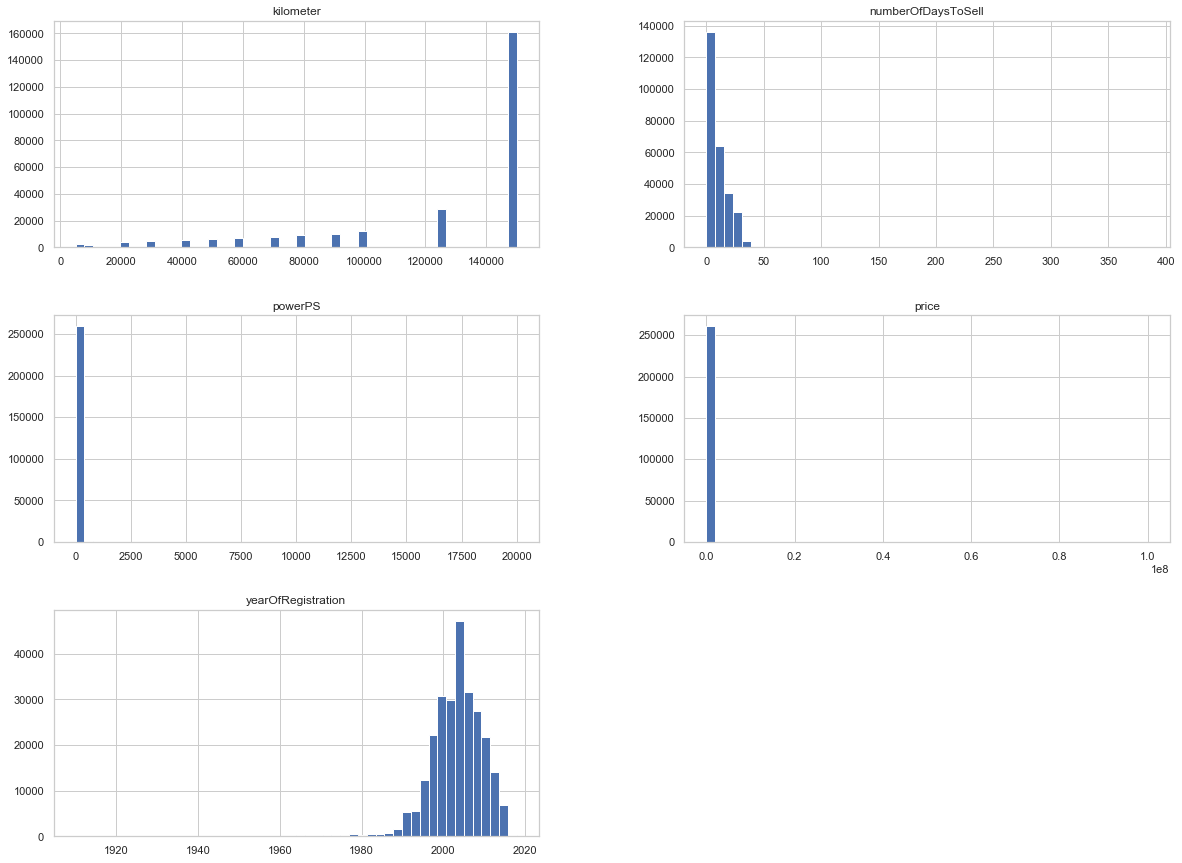

In [387]:
autos.hist(bins=50,  figsize=(20,15))
plt.show()

From the initial analysis above we can notice the following:

* Number of days to sell is extremely skewed to the right
* Power PS is extremely skewed to the right
* Price is extremely skewed to the right
* Year of registration has a clear normal distribution, although it is extremely skewed to the left due to some possible outliers

Hence further investigations are necessary, as the skewness might be due to user typos. A boxplot chart might be helpful.


[Text(0, 0.5, 'Number 0f Days To Sell')]

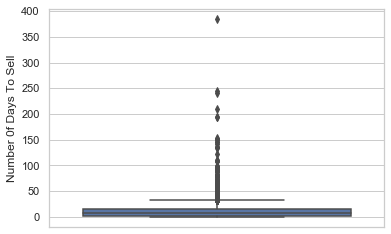

In [388]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['numberOfDaysToSell'])
ax.set(ylabel = "Number 0f Days To Sell")

[Text(0, 0.5, 'Power PS')]

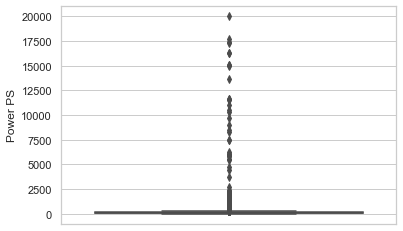

In [389]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['powerPS'])
ax.set(ylabel = "Power PS")

[Text(0, 0.5, 'Price')]

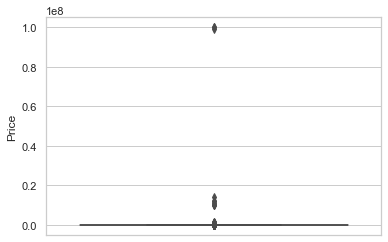

In [390]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['price'])
ax.set(ylabel = "Price")

We can notice outliers in all of them, reason for skewness. They are influencing the slope considerably. We will remove them for now.

In [391]:
print((autos['numberOfDaysToSell']>50).value_counts())
print((autos['powerPS']>1000).value_counts())
print((autos['powerPS']<40).value_counts())
print((autos['price']>80000).value_counts())
print((autos['price']<100).value_counts())
print((autos['yearOfRegistration']<1990).value_counts())

False    260837
True        108
Name: numberOfDaysToSell, dtype: int64
False    260816
True        129
Name: powerPS, dtype: int64
False    250434
True      10511
Name: powerPS, dtype: int64
False    260598
True        347
Name: price, dtype: int64
False    256926
True       4019
Name: price, dtype: int64
False    255239
True       5706
Name: yearOfRegistration, dtype: int64


In [392]:
# Get list of indexes for which column numberOfDaysToSell has value >= 50
indexList = autos[autos['numberOfDaysToSell'] >= 50].index

# Delete these row indexes from dataFrame
autos.drop(indexList , inplace=True)

In [393]:
# Get list of indexes for which column powerPS has value >= 1000
indexList = autos[autos['powerPS'] >= 1000].index

# Delete these row indexes from dataFrame
autos.drop(indexList , inplace=True)

# Get list of indexes for which column powerPS has value <= 40
indexList = autos[autos['powerPS'] <= 40].index

# Delete these row indexes from dataFrame
autos.drop(indexList , inplace=True)

In [394]:
# Get list of indexes for which column price has value >= 80000
indexList = autos[autos['price'] >= 80000].index

# Delete these row indexes from dataFrame
autos.drop(indexList , inplace=True)

# Get list of indexes for which column price has value <= 100
indexList = autos[autos['price'] < 100].index

# Delete these row indexes from dataFrame
autos.drop(indexList , inplace=True)

In [395]:
# We do not work with collections or old cars, thus any car older than 1990 will not be considered
# Get list of indexes for which column price has value >= 80000
indexList = autos[autos['yearOfRegistration'] <= 1990].index

# Delete these row indexes from dataFrame
autos.drop(indexList , inplace=True)

[Text(0, 0.5, 'Numbers of Days To Sell')]

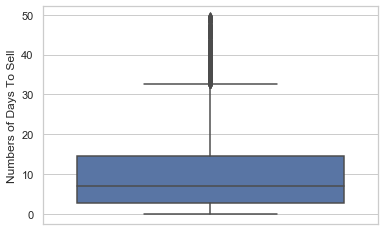

In [396]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['numberOfDaysToSell'])
ax.set(ylabel = "Numbers of Days To Sell")

[Text(0, 0.5, 'Power PS')]

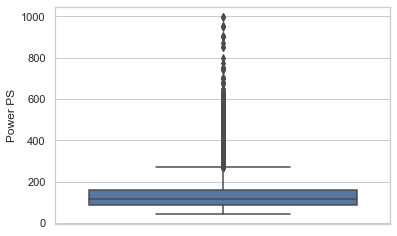

In [397]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['powerPS'])
ax.set(ylabel = "Power PS")

[Text(0, 0.5, 'Price')]

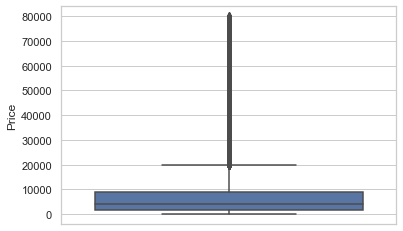

In [398]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['price'])
ax.set(ylabel = "Price")

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Repaired Damage (No/Yes)')]

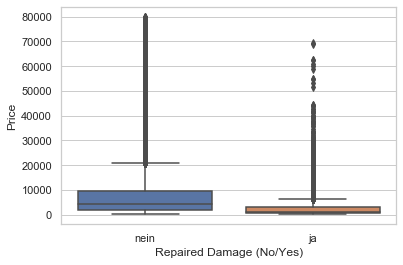

In [399]:
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.boxplot(y=autos['price'], x=autos['notRepairedDamage'])
ax.set(ylabel = "Price", xlabel = "Repaired Damage (No/Yes)")

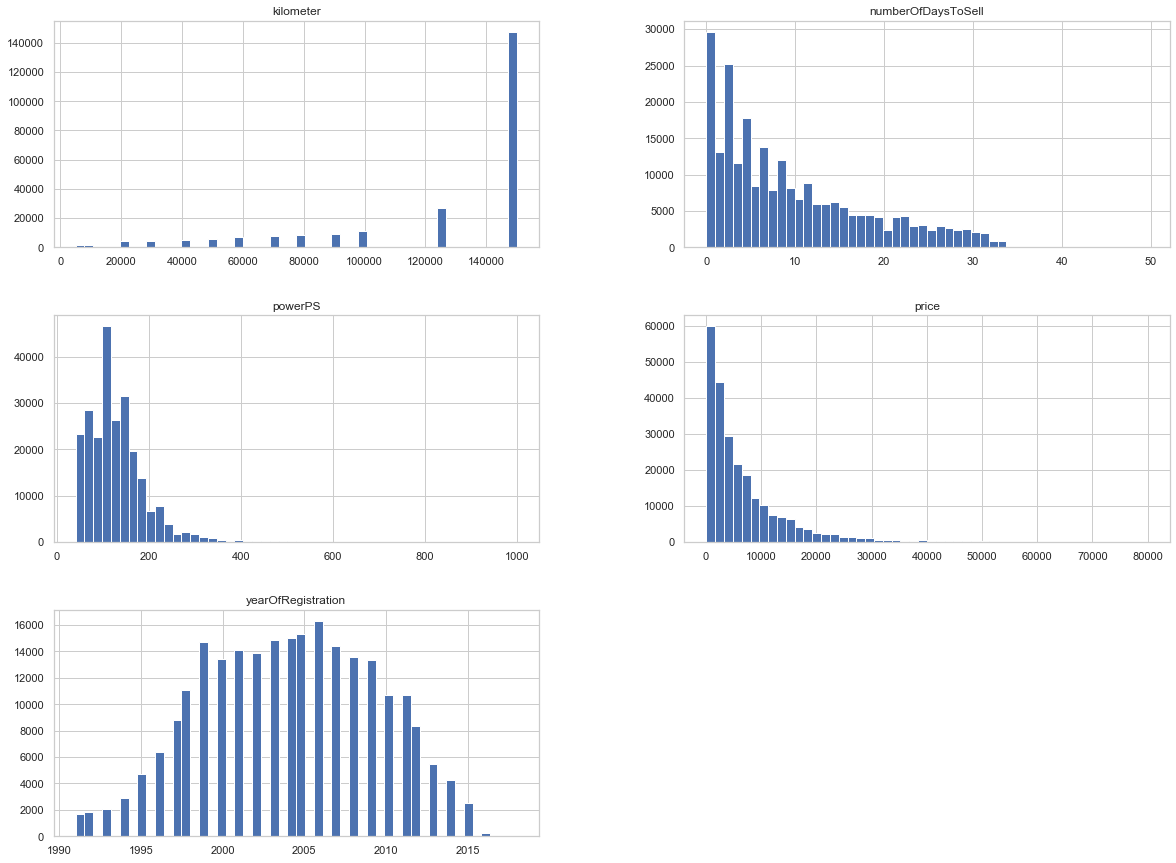

In [400]:
autos.hist(bins=50,  figsize=(20,15))
plt.show()

We wish to analyze the relationship between "Year of Registration" and "Prices". We can see from the scatter plot below that indeed price increases for some older cars, that could be due to collection models.

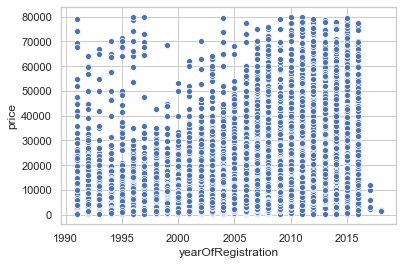

In [312]:
sns.scatterplot(
    x='yearOfRegistration',
    y='price',
    data=autos)

We decided to apply the log function to the feature price see if we get a more normal distribution.

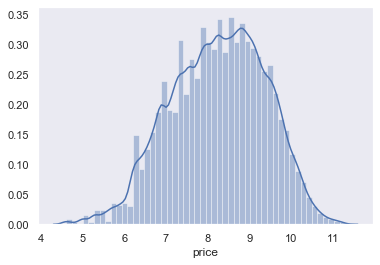

In [313]:
log_price = np.log(autos['price'])
sns.set_style("dark")
sns.distplot(log_price,label="Logarithmic price")

In [314]:
autos.describe().round(2)

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
count,240592.00,240592.00,240592.00,240592.00,240592.00
mean,6745.49,2004.04,129.82,123909.19,9.71
std,7738.57,5.36,61.58,39668.83,8.47
min,100.00,1991.00,41.00,5000.00,0.03
25%,1699.00,2000.00,86.00,100000.00,2.72
50%,3999.00,2004.00,116.00,150000.00,7.03
75%,8900.00,2008.00,160.00,150000.00,14.68
max,79980.00,2018.00,999.00,150000.00,49.62


In [315]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240592 entries, 3 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               240592 non-null  int64  
 1   vehicleType         240592 non-null  object 
 2   yearOfRegistration  240592 non-null  int64  
 3   gearbox             240592 non-null  object 
 4   powerPS             240592 non-null  int64  
 5   model               240592 non-null  object 
 6   kilometer           240592 non-null  int64  
 7   fuelType            240592 non-null  object 
 8   brand               240592 non-null  object 
 9   notRepairedDamage   240592 non-null  object 
 10  numberOfDaysToSell  240592 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 32.0+ MB


We can also use the pandas scatter_matrix() function to check correlation. This function plots every numerical attribute against other numerical attribute. To reduce the amount of plots, let's focus on some few attributes that seem most correlated with median housing value:

In [401]:
corr_matrix = autos.corr()
corr_matrix

,price,yearOfRegistration,powerPS,kilometer,numberOfDaysToSell
price,1.000000,0.629137,0.600101,-0.483680,0.135361
yearOfRegistration,0.629137,1.000000,0.225181,-0.545447,0.096220
powerPS,0.600101,0.225181,1.000000,-0.017946,0.070457
kilometer,-0.483680,-0.545447,-0.017946,1.000000,-0.087551
numberOfDaysToSell,0.135361,0.096220,0.070457,-0.087551,1.000000


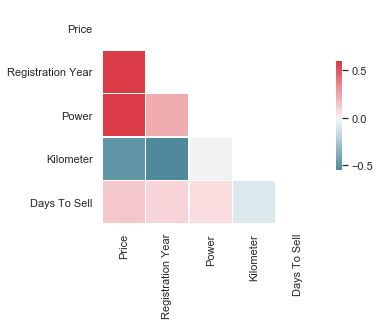

In [402]:
autos_num_corr = autos.copy()
autos_num_corr = autos_num_corr.drop(autos_cat, axis=1)
correlation_matrix = autos_num_corr.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.6, center=0,
            xticklabels=('Price','Registration Year','Power','Kilometer', 'Days To Sell'),
            yticklabels=('Price','Registration Year','Power','Kilometer', 'Days To Sell'),
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [403]:
corr_matrix['price'].sort_values(ascending=False)

price                 1.000000
yearOfRegistration    0.629137
powerPS               0.600101
numberOfDaysToSell    0.135361
kilometer            -0.483680
Name: price, dtype: float64

In [404]:
#attributes = ["price", "yearOfRegistration", "powerPS", "kilometer", "numberOfDaysToSell"]
#scatter_matrix(autos[attributes], figsize=(12,8))

In [405]:
# get top 10 most frequent names
n = 10
top10 = autos['brand'].value_counts()[:n]

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Brand')]

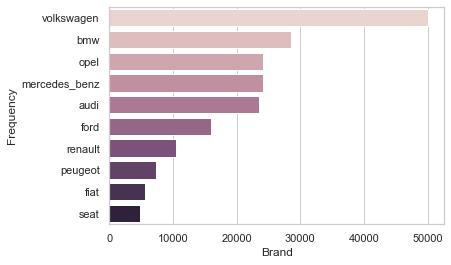

In [406]:
top10brand=sns.countplot(y="brand", data=autos, palette=sns.cubehelix_palette(10),
              order=autos.brand.value_counts().iloc[:10].index)
top10brand.set(xlabel="Brand", ylabel = "Frequency")

In [407]:
price = autos['price'].values
brand = autos['brand'].values

price_tr=[None]*256016
brand_tr=[None]*256016

for i in range(len(autos)):
    if brand[i] in top10.index:
        price_tr[i] = price[i]
        brand_tr[i] = brand[i]

[Text(0, 0.5, 'Price'), Text(0.5, 0, 'Top 10 Brands')]

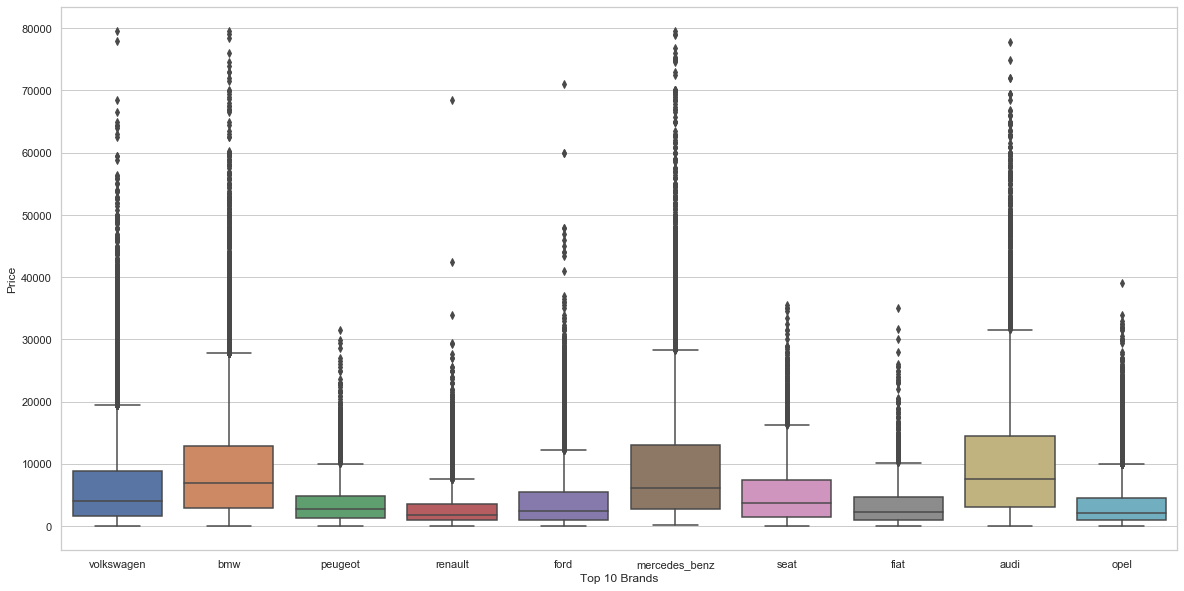

In [408]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
bxp = sns.boxplot(y=price_tr, x=brand_tr)
bxp.set(ylabel = "Price", xlabel = "Top 10 Brands")

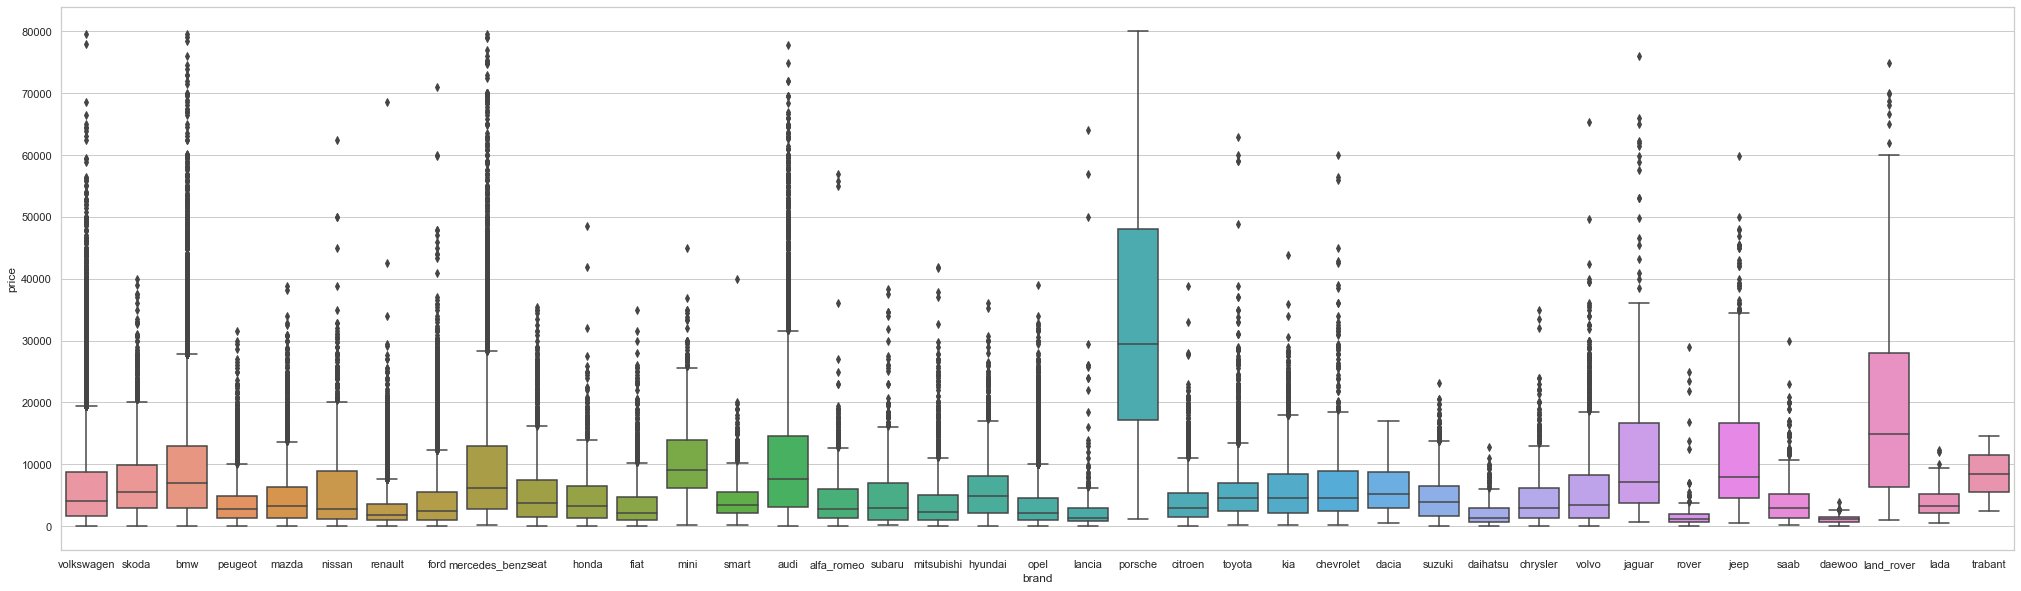

In [409]:
plt.figure(figsize=(35,10))
sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
sns.boxplot(y=autos['price'], x=autos['brand'])

In [411]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240592 entries, 3 to 371527
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               240592 non-null  int64  
 1   vehicleType         240592 non-null  object 
 2   yearOfRegistration  240592 non-null  int64  
 3   gearbox             240592 non-null  object 
 4   powerPS             240592 non-null  int64  
 5   model               240592 non-null  object 
 6   kilometer           240592 non-null  int64  
 7   fuelType            240592 non-null  object 
 8   brand               240592 non-null  object 
 9   notRepairedDamage   240592 non-null  object 
 10  numberOfDaysToSell  240592 non-null  float64
dtypes: float64(1), int64(4), object(6)
memory usage: 32.0+ MB


## 5. TEST-TRAIN SPLIT

__MODEL 1:__ Considers the __car features__ (model, year, power, fuel type, brand, etc.) as explanatory/independent variables and has __price__ as response/dependent variable.

In [412]:
autos_label_m1 = autos['price'].copy()
autos_features_m1 = autos.drop(['numberOfDaysToSell','price'], axis=1)

autos_features_m1_tr, autos_features_m1_test, autos_label_m1_tr, autos_label_m1_test \
    = train_test_split(autos_features_m1, autos_label_m1, test_size = 0.2, random_state=24)

In [413]:
print(autos_label_m1_tr.shape)
print(autos_label_m1_test.shape)
print(autos_features_m1_tr.shape)
print(autos_features_m1_test.shape)

(192473,)
(48119,)
(192473, 9)
(48119, 9)


In [414]:
autos_features_m1_tr.head()

,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
363641,limousine,2004,manuell,131,passat,150000,diesel,volkswagen,nein
270905,limousine,1998,manuell,101,a3,150000,benzin,audi,nein
68641,limousine,2000,manuell,163,a6,150000,benzin,audi,nein
70934,limousine,2013,automatik,184,3er,90000,diesel,bmw,nein
60102,limousine,2014,manuell,140,golf,40000,benzin,volkswagen,nein


In [415]:
autos_label_m1_tr.head()

363641     4999
270905     1500
68641      2399
70934     24500
60102     14999
Name: price, dtype: int64

In [416]:
#final check for missing values:
for i in autos_features_m1_tr:
    print(i, autos[i].isnull().sum() )
for i in autos_features_m1_test:
    print(i, autos[i].isnull().sum() )

vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0
vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0


__MODEL 2:__ Considers the __car features__ (model, year, power, fuel type, brand, etc.) + __price__ as explanatory/independent variables and has __numberOfDaysToSell__ as response/dependent variable.

In [417]:
autos_label_m2 = autos['numberOfDaysToSell'].copy()
autos_features_m2 = autos.drop('numberOfDaysToSell', axis=1)

autos_features_m2_tr, autos_features_m2_test, autos_label_m2_tr, autos_label_m2_test \
    = train_test_split(autos_features_m2, autos_label_m2, test_size = 0.2, random_state=24)

In [418]:
print(autos_label_m2_tr.shape)
print(autos_label_m2_test.shape)
print(autos_features_m2_tr.shape)
print(autos_features_m2_test.shape)

(192473,)
(48119,)
(192473, 10)
(48119, 10)


In [419]:
autos_features_m2_tr.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand,notRepairedDamage
363641,4999,limousine,2004,manuell,131,passat,150000,diesel,volkswagen,nein
270905,1500,limousine,1998,manuell,101,a3,150000,benzin,audi,nein
68641,2399,limousine,2000,manuell,163,a6,150000,benzin,audi,nein
70934,24500,limousine,2013,automatik,184,3er,90000,diesel,bmw,nein
60102,14999,limousine,2014,manuell,140,golf,40000,benzin,volkswagen,nein


In [420]:
autos_label_m2_tr.head()

363641     4.720833
270905     2.947569
68641      2.970799
70934     11.386956
60102      9.949120
Name: numberOfDaysToSell, dtype: float64

In [421]:
#final check for missing values:
for i in autos_features_m2_tr:
    print(i, autos[i].isnull().sum() )
for i in autos_features_m2_test:
    print(i, autos[i].isnull().sum() )

price 0
vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0
price 0
vehicleType 0
yearOfRegistration 0
gearbox 0
powerPS 0
model 0
kilometer 0
fuelType 0
brand 0
notRepairedDamage 0


## 6. PREPARE THE DATA FOR MACHINE LEARNING ALGORITHMS

### Model 1

Numerical and categorical values are treated differently. Thus, let us split the dataset into two subsets: numerical and categorical.

In [422]:
autos_features_m1_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192473 entries, 363641 to 1408
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicleType         192473 non-null  object
 1   yearOfRegistration  192473 non-null  int64 
 2   gearbox             192473 non-null  object
 3   powerPS             192473 non-null  int64 
 4   model               192473 non-null  object
 5   kilometer           192473 non-null  int64 
 6   fuelType            192473 non-null  object
 7   brand               192473 non-null  object
 8   notRepairedDamage   192473 non-null  object
dtypes: int64(3), object(6)
memory usage: 14.7+ MB


In [423]:
autos_features_m1_tr_num = autos_features_m1_tr.drop(autos_cat, axis=1)
autos_features_m1_tr_num.head()

,yearOfRegistration,powerPS,kilometer
363641,2004,131,150000
270905,1998,101,150000
68641,2000,163,150000
70934,2013,184,90000
60102,2014,140,40000


In [424]:
autos_num = ['yearOfRegistration', 'powerPS', 'kilometer']
autos_features_m1_tr_cat = autos_features_m1_tr.drop(autos_num, axis=1)

In [425]:
autos_features_m1_tr_cat.head()

,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage
363641,limousine,manuell,passat,diesel,volkswagen,nein
270905,limousine,manuell,a3,benzin,audi,nein
68641,limousine,manuell,a6,benzin,audi,nein
70934,limousine,automatik,3er,diesel,bmw,nein
60102,limousine,manuell,golf,benzin,volkswagen,nein


Next, we create a class to select numerical or categorical columns since Scikit-Learn doesn't handle DataFrames.

In [426]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.attribute_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Next, a few data transformations will be carried out. First, __Feature scaling__, which is used to prevent ML algorithms to create bias towards variables with bigger values. We will be using the Standard Scaler transform. The idea behind *StandardScaler()* is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1. In case of multivariate data, this is done feature-wise (in other words independently for each column of the data). Given the distribution of the data, each value in the dataset will have the mean value subtracted, and then divided by the standard deviation of the whole dataset (or feature in the multivariate case).

In [427]:
# The imputer is fittet on the training data. It can then also be applied to the test data (without a refit)
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(autos_num)),
        ('std_scaler', StandardScaler())
    ])

# We run the pipeline to check, whether it runs with no problems
temp = num_pipeline.fit_transform(autos_features_m1_tr)

In [428]:
autos_features_m1_tr_num_transf = pd.DataFrame(temp, columns=autos_features_m1_tr_num.columns, index=autos_features_m1_tr_num.index)
autos_features_m1_tr_num_transf.head()

,yearOfRegistration,powerPS,kilometer
363641,-0.008535,0.019721,0.657790
270905,-1.127409,-0.467443,0.657790
68641,-0.754451,0.539361,0.657790
70934,1.669777,0.880376,-0.854135
60102,1.856256,0.165870,-2.114073


Now we need to create one binary attribute per category. This is called **one-hot encoding**, because only one attribute will be equal to 1 (hot), while the other will be 0 (cold).

In [429]:
# One-Hot-Encoder replaces categorical features by boolean features, stating wether a certain category is true or not
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(autos_cat)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

# We run the pipeline to check, whether it runs with no problems
temp = cat_pipeline.fit_transform(autos_features_m1_tr)

After one-hot encoding, we get a matrix with hundreds of columns, and the matrix is full of 0s except for a single 1 per row. The result is a SciPy sparse matrix that only stores the location of the nonzero element in order to reduce memory usage.

In [430]:
#Combine both imputers and get cleaned data
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
autos_features_prepared_m1_tr = full_pipeline.fit_transform(autos_features_m1_tr)

In [431]:
autos_features_prepared_m1_tr

array([[-0.00853467,  0.01972061,  0.65779028, ...,  0.        ,
         0.        ,  1.        ],
       [-1.12740932, -0.46744271,  0.65779028, ...,  0.        ,
         0.        ,  1.        ],
       [-0.7544511 ,  0.53936147,  0.65779028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 2.04273551, -0.22386105, -2.61804809, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.92386086, -0.88965091, -1.35811025, ...,  0.        ,
         0.        ,  1.        ],
       [-0.94093021,  1.02652479,  0.65779028, ...,  0.        ,
         0.        ,  1.        ]])

In [432]:
print(autos_features_prepared_m1_tr.shape)
print(autos_label_m1_tr.shape)
print(type(autos_features_prepared_m1_tr))
print(type(autos_label_m1_tr))

(192473, 308)
(192473,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [433]:
#Converting autos_label_m1_tr and autos_label_m1_test to numpy array
autos_label_m1_tr = autos_label_m1_tr.to_numpy()
autos_label_m1_test = autos_label_m1_test.to_numpy()

In [434]:
type(autos_label_m1_tr)

numpy.ndarray

### Model 2

In [435]:
autos_features_m2_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192473 entries, 363641 to 1408
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               192473 non-null  int64 
 1   vehicleType         192473 non-null  object
 2   yearOfRegistration  192473 non-null  int64 
 3   gearbox             192473 non-null  object
 4   powerPS             192473 non-null  int64 
 5   model               192473 non-null  object
 6   kilometer           192473 non-null  int64 
 7   fuelType            192473 non-null  object
 8   brand               192473 non-null  object
 9   notRepairedDamage   192473 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.2+ MB


In [436]:
autos_features_m2_tr_num = autos_features_m2_tr.drop(autos_cat, axis=1)
autos_features_m2_tr_num.head()

,price,yearOfRegistration,powerPS,kilometer
363641,4999,2004,131,150000
270905,1500,1998,101,150000
68641,2399,2000,163,150000
70934,24500,2013,184,90000
60102,14999,2014,140,40000


In [437]:
autos_num_2 = ['price','yearOfRegistration', 'powerPS', 'kilometer']
autos_features_m2_tr_cat = autos_features_m2_tr.drop(autos_num_2, axis=1)
autos_features_m2_tr_cat.head()

,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage
363641,limousine,manuell,passat,diesel,volkswagen,nein
270905,limousine,manuell,a3,benzin,audi,nein
68641,limousine,manuell,a6,benzin,audi,nein
70934,limousine,automatik,3er,diesel,bmw,nein
60102,limousine,manuell,golf,benzin,volkswagen,nein


In [438]:
# The imputer is fittet on the training data. It can then also be applied to the test data (without a refit)
num_pipeline_2 = Pipeline([
        ('selector', DataFrameSelector(autos_num_2)),
        ('std_scaler', StandardScaler())
    ])

# We run the pipeline to check, whether it runs with no problems
temp = num_pipeline_2.fit_transform(autos_features_m2_tr)

In [439]:
autos_features_m2_tr_num_transf = pd.DataFrame(temp, columns=autos_features_m2_tr_num.columns, index=autos_features_m2_tr_num.index)
autos_features_m2_tr_num_transf.head()

,price,yearOfRegistration,powerPS,kilometer
363641,-0.225904,-0.008535,0.019721,0.657790
270905,-0.678864,-1.127409,-0.467443,0.657790
68641,-0.562485,-0.754451,0.539361,0.657790
70934,2.298582,1.669777,0.880376,-0.854135
60102,1.068638,1.856256,0.165870,-2.114073


In [440]:
# One-Hot-Encoder replaces categorical features by boolean features, stating wether a certain category is true or not
cat_pipeline_2 = Pipeline([
        ('selector', DataFrameSelector(autos_cat)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

# We run the pipeline to check, whether it runs with no problems
temp = cat_pipeline_2.fit_transform(autos_features_m2_tr)

In [441]:
#Combine both imputers and get cleaned data
full_pipeline_2 = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline_2),
        ("cat_pipeline", cat_pipeline_2),
    ])
autos_features_prepared_m2_tr = full_pipeline_2.fit_transform(autos_features_m2_tr)
autos_features_prepared_m2_tr

array([[-0.2259037 , -0.00853467,  0.01972061, ...,  0.        ,
         0.        ,  1.        ],
       [-0.6788639 , -1.12740932, -0.46744271, ...,  0.        ,
         0.        ,  1.        ],
       [-0.56248459, -0.7544511 ,  0.53936147, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 2.62221787,  2.04273551, -0.22386105, ...,  0.        ,
         0.        ,  1.        ],
       [-0.22577425,  0.92386086, -0.88965091, ...,  0.        ,
         0.        ,  1.        ],
       [-0.00570213, -0.94093021,  1.02652479, ...,  0.        ,
         0.        ,  1.        ]])

In [442]:
print(autos_features_prepared_m2_tr.shape)
print(autos_label_m2_tr.shape)
print(type(autos_features_prepared_m2_tr))
print(type(autos_label_m2_tr))

(192473, 309)
(192473,)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [443]:
#Converting autos_label_m2_tr and autos_label_m2_test to numpy array
autos_label_m2_tr = autos_label_m2_tr.to_numpy()
autos_label_m2_test = autos_label_m2_test.to_numpy()

In [444]:
type(autos_label_m2_tr)

numpy.ndarray

## 6. MODELS EVALUATION

In [445]:
def display_scores(scores):
    print("Scores: ", scores.round(2))
    print('Mean:%5.2f'%scores.mean().round(2))
    print('Standard deviation:%5.2f'%scores.std().round(2))

### Model 1

### Linear Regression

Since we have many columns after the data transformations, let's create a function for backward elimination. In this process, all independent variables are entered into the regression at first, then each one is deleted, one at a time, if they do not contribute to the performance of the model.

In [191]:
#Backward Elimination with p-values
def backwardElimination_p(y, x, sl):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
    regressor_OLS.summary()
    return x

In [192]:
#takes a long time to run
SL = 0.05
X_opt = autos_features_prepared_m1_tr
autos_opt = backwardElimination_p(autos_label_m1_tr, X_opt, SL)

The OLS model does not is not include an intercept by default, thus it should be added.

In [193]:
autos_opt = np.append(arr = np.ones((192473,1)).astype(int), values = autos_opt, axis=1)

In [194]:
OLS_lin_reg = sm.OLS(autos_label_m1_tr, autos_opt).fit()

In [195]:
print(OLS_lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2952.
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        12:58:03   Log-Likelihood:            -1.8507e+06
No. Observations:              192473   AIC:                         3.702e+06
Df Residuals:                  192242   BIC:                         3.704e+06
Df Model:                         230                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2398.5100     58.947     40.690      0.0

In [471]:
OLS_pred = OLS_lin_reg.predict(autos_opt)
OLS_lin_mse = mean_squared_error(autos_label_m1_tr, OLS_pred)
OLS_lin_rmse = np.sqrt(OLS_lin_mse)
OLS_lin_rmse.round(2)

3628.58

We cannot use __cross_val_score__ directly on statsmodels objects, because of different interface. In statsmodels the training data is passed directly into the constructor and a separate object contains the result of model estimation. However, we can write a universal wrapper to make statsmodels objects look like sklearn estimators.

In [99]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [410]:
OLS_lin_reg_scores = cross_val_score(SMWrapper(sm.OLS), autos_opt, autos_label_m1_tr, 
                                 scoring="neg_mean_squared_error", cv=10)
OLS_lin_reg_rmse_scores = np.sqrt(-OLS_lin_reg_scores)
display_scores(OLS_lin_reg_rmse_scores)

Scores:  [3759.48 3653.29 3681.91 3620.79 3667.49 3654.4  3590.94 3555.26 3538.2
 3631.85]
Mean:3635.36
Standard deviation:61.11


### Decision Tree

The CART algorithm works similar to a Decision Tree Classifiers, however, instead of trying to split the training set in a way that minimizes the impurity, it tries to split the training set in a way that minimizes the MSE.

Usually, to avoid overfitting the training data, we need to restrict the Decision Tree's freedom, the so called regularization. Restricting the maximum depth of a Decision Tree is one way to regularize it.

In [197]:
tree = DecisionTreeRegressor(random_state=24)
tree.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=24, splitter='best')

In [198]:
predictions = tree.predict(autos_features_prepared_m1_tr)
tree_mse = mean_squared_error(autos_label_m1_tr, predictions)
tree_rmse = np.sqrt(tree_mse)
print('%5.4f'%tree_rmse)

1101.2015


No error at all? No, it is much more likely that the model has badly overfit the data. Since we are still not confident about our model, we should not use the test set yet, so we use part of the training set for training and part of it for model validation, the so called cross-validation.

In [199]:
scores = cross_val_score(tree, autos_features_prepared_m1_tr, autos_label_m1_tr,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [200]:
display_scores(tree_rmse_scores)

Scores:  [2645.26 2619.26 2680.74 2609.86 2642.96 2624.77 2522.31 2562.33 2463.46
 2517.6 ]
Mean:2588.86
Standard deviation:65.68


With the Decision Tree results, we can notice an interesting (and very typical) behaviour. The in-sample error (i.e. the error on the trainings data) is very low, while cross-validation shows significantly larger error.

The reason is that the cross-validation score is computed with out-of-sample data (i.e. the error is computed on data points, which were not used within the traning). This is a typical behaviour of *overfitting*, where the decision tree simply *memorises* the data it is trained with, not yielding a better prediction.

### Random Forest

If we aggregate predictions of a group of predictors (such as classifiers or regressors), we will often get a better prediction than with the best individual predictor. A group of predictors is called *ensemble*, thus, the so called *Ensemble Learning*.

As an example of an Ensemble method, we can train a group of Decision Tree classifiers/regressors, each on a different random subset of the training set. To obtain predictions, we obtain the predictions of all the individual trees, then predict the class/regressor that gets the best results. Such an ensemble of Decision Trees is called a Random Forest.

The most popular Ensemble methods are: *bagging, boosting, and stacking*. Here we use the same training algorithm (Random Forest in this case) for every predictor and train them on different subsets of the training set. When sampling is performed with replacement, this method is called bagging (or *bootstrap*). When sampling is performed without replacement, it is called pasting.

In sum, a Random Forest is an ensemble of Decision Trees, generally trained via the bagging method. We will use in this model a RandomForestRegressor for our regression task. This is a regression task because the target value is continuous (price).

In [205]:
forest = RandomForestRegressor(random_state=24, n_estimators=10) #n_estimators = number of trees
forest.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=24, verbose=0, warm_start=False)

In [206]:
predictions = forest.predict(autos_features_prepared_m1_tr)
forest_mse = mean_squared_error(autos_label_m1_tr, predictions)
forest_rmse = np.sqrt(forest_mse)
print("rmse = ", '%5.4f'%forest_rmse)

some_data = autos_features_m1_tr.iloc[:5]
some_labels = autos_label_m1_tr[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", forest.predict(some_data_prepared))
print("Labels: ", list(some_labels))

rmse =  1329.0491
Predictions:  [ 3474.53333532  1635.41873286  2299.2        28745.
 15907.84583333]
Labels:  [4999, 1500, 2399, 24500, 14999]


In [207]:
forest_scores = cross_val_score(forest, autos_features_prepared_m1_tr, autos_label_m1_tr,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores:  [2326.6  2241.15 2282.04 2224.19 2354.45 2313.82 2176.22 2186.58 2234.25
 2235.36]
Mean:2257.47
Standard deviation:56.56


### Support Vector Machine

SVM support both classification and regression tasks, hence we will also try out our model using SVM Regression. In this case, the SVM tries to fit as many instances as possible on the "street", while limiting margin violations (i.e., instances off the street). The width of the street is controlled by the hyperparameter __epsilon__.

In [201]:
svm_reg = LinearSVR(random_state=24, max_iter=1000, epsilon=10)
svm_reg.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

LinearSVR(C=1.0, dual=True, epsilon=10, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=24, tol=0.0001, verbose=0)

In [202]:
predictions = svm_reg.predict(autos_features_prepared_m1_tr)
svm_reg_mse = mean_squared_error(autos_label_m1_tr, predictions)
svm_reg_rmse = np.sqrt(svm_reg_mse)
print('%5.4f'%svm_reg_rmse)

4476.3532


In [203]:
svm_reg_scores = cross_val_score(svm_reg, autos_features_prepared_m1_tr, autos_label_m1_tr, 
                                 scoring="neg_mean_squared_error", cv=10)
svm_reg_rmse_scores = np.sqrt(-svm_reg_scores)
display_scores(svm_reg_rmse_scores)

Scores:  [4544.41 4466.98 4540.69 4556.88 4524.3  4603.39 4416.56 4394.44 4373.54
 4498.42]
Mean:4491.96
Standard deviation:72.58


### Regression Deep Neural Network (MLP)

In [208]:
X_train, X_valid, y_train, y_valid = train_test_split(autos_features_prepared_m1_tr, autos_label_m1_tr,
                                                     test_size = 0.2, random_state=24)

In [209]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(153978, 308)
(38495, 308)
(153978,)
(38495,)


Creating the deep neural network using a __Sequential API__. Since the dataset is somewhat noisy, only two dense hiden layers are added; the first one with 30 neurons and the second one with 5 neurons. The output layer has a single neuron, since the goal is to predict only one variable.

In [210]:
dnn = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1)
])

After a model is created, it must be compiled. The loss function selected for this regression DNN is the __mean squared error__ and the optimizer used is __Adam__. Adam was selected over SGD to avoid issues such as exploding gradients, to speed up training, and to reach better solution. Adam keeps track of an exponentially decaying average of past gradients and past squared gradients. The momentum decay hyperparameter beta_1 is usually initialized to 0.9, while the scaling decay hyperparameter beta_2 is often initialized to 0.999).

In [211]:
#dnn_opt = keras.optimizers.SGD(clipvalue=1.0, lr=0.001)
dnn_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
dnn.compile(loss="mean_squared_error", 
            optimizer=dnn_opt)

In [481]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                9270      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 9,431
Trainable params: 9,431
Non-trainable params: 0
_________________________________________________________________


__Callbacks__ arguments such as Model Checkpoint will save the model with the best performance. This way, there is no need to worry about training for too long and overfitting the training set as the last model saved after training will be restored and this will always be the best model on the validation set. Additionally, as EarlyStopping callback will interrupt training when it measures no progress on the validation set for a number of epochs (_patience argument_), and it will automatically roll back to the best model.

In [213]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("dnn_m1", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = dnn.fit(X_train, y_train, epochs=40,
                 validation_data=(X_valid, y_valid),
                 callbacks=[checkpoint_cb, early_stopping_cb])
dnn = keras.models.load_model("dnn_m1") #roll back to best model

Train on 153978 samples, validate on 38495 samples
Epoch 1/40
153856/153978 [============================>.] - ETA: 0s - loss: 49183760.9263WARNING:tensorflow:From C:\Users\igorm\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dnn_m1\assets
153978/153978 [==============================] - 15s 98us/sample - loss: 49154948.1083 - val_loss: 14668286.2292
Epoch 2/40
153978/153978 [==============================] - 14s 91us/sample - loss: 13601202.1243 - val_loss: 12166530.5746
Epoch 3/40
153978/153978 [==============================] - 14s 92us/sample - loss: 12385132.0616 - val_loss: 11678098.4655
Epoch 4/40
153978/153978 [==============================] - 14s 90us/sample - loss: 

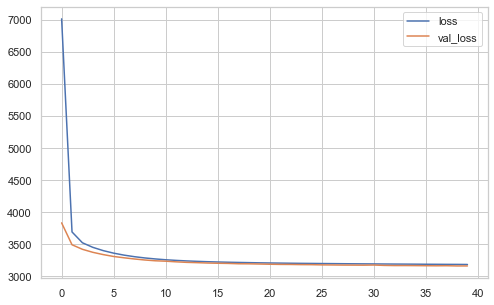

In [214]:
dnn_1_df_hist = pd.DataFrame(history.history)
dnn_1_df_hist = np.sqrt(dnn_1_df_hist)
dnn_1_df_hist.plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [500]:
mse_dnn = dnn.evaluate(autos_features_prepared_m1_tr, autos_label_m1_tr)
rmse_dnn = np.sqrt(mse_dnn)
print(rmse_dnn)

192473/192473 [==============================] - 5s 24us/sample - loss: 10078994.3644
3174.743196603621


In [502]:
X_new = autos_features_prepared_m1_tr[:5]
y_pred = dnn.predict(X_new)
print(y_pred)
print(autos_label_m1_tr[:5])

[[ 3996.4707 ]
 [  128.20117]
 [ 1265.4404 ]
 [21026.986  ]
 [18954.63   ]]
[ 4999  1500  2399 24500 14999]


Of all models tested herein, __Random Forest__ is the one yielding the smallest *rmse*. However, we can see that the score on the training set is still much lower than on the validation set, meaning that the model is overfitting the training set. In the next section we will aim to optimize our hyperparameters for better results. In addition, we will also attempt to improve the performance of our __Neural Network__.

### Model 2

### Linear Regression

In [218]:
SL = 0.05
X_opt_2 = autos_features_prepared_m2_tr
autos_opt_2 = backwardElimination_p(autos_label_m2_tr, X_opt_2, SL)

In [219]:
autos_opt_2 = np.append(arr = np.ones((192473,1)).astype(int), values = autos_opt_2, axis=1)

In [220]:
OLS_lin_reg_2 = sm.OLS(autos_label_m2_tr, autos_opt_2).fit()

In [221]:
print(OLS_lin_reg_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     41.79
Date:                Tue, 26 May 2020   Prob (F-statistic):               0.00
Time:                        14:32:03   Log-Likelihood:            -6.8199e+05
No. Observations:              192473   AIC:                         1.364e+06
Df Residuals:                  192348   BIC:                         1.366e+06
Df Model:                         124                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.095e+12    3.8e+12      0.288      0.7

In [222]:
OLS_pred_2 = OLS_lin_reg_2.predict(autos_opt_2)
OLS_lin_mse_2 = mean_squared_error(autos_label_m2_tr, OLS_pred_2)
OLS_lin_rmse_2 = np.sqrt(OLS_lin_mse_2)
OLS_lin_rmse_2.round(2)

8.37

In [223]:
OLS_lin_reg_scores_2 = cross_val_score(SMWrapper(sm.OLS), autos_opt_2, autos_label_m2_tr, 
                                 scoring="neg_mean_squared_error", cv=10)
OLS_lin_reg_rmse_scores_2 = np.sqrt(-OLS_lin_reg_scores_2)
display_scores(OLS_lin_reg_rmse_scores_2)

Scores:  [8.3  8.38 8.44 8.35 8.4  8.4  8.39 8.41 8.35 8.31]
Mean: 8.37
Standard deviation: 0.04


### Decision Tree

In [224]:
tree_2 = DecisionTreeRegressor(random_state=24)
tree_2.fit(autos_features_prepared_m2_tr, autos_label_m2_tr)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=24, splitter='best')

In [225]:
predictions_2 = tree_2.predict(autos_features_prepared_m2_tr)
tree_mse_2 = mean_squared_error(autos_label_m2_tr, predictions_2)
tree_rmse_2 = np.sqrt(tree_mse_2)
print('%5.4f'%tree_rmse_2)

2.2031


In [226]:
scores_2 = cross_val_score(tree_2, autos_features_prepared_m2_tr, autos_label_m2_tr,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores_2 = np.sqrt(-scores_2)

In [227]:
display_scores(tree_rmse_scores_2)

Scores:  [11.1  11.21 11.17 11.14 11.19 11.13 11.09 11.24 11.21 11.1 ]
Mean:11.16
Standard deviation: 0.05


### Random Forest

In [228]:
forest_2 = RandomForestRegressor(random_state=24, n_estimators=10) #n_estimators = number of trees
forest_2.fit(autos_features_prepared_m2_tr, autos_label_m2_tr)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=24, verbose=0, warm_start=False)

In [229]:
predictions_2 = forest_2.predict(autos_features_prepared_m2_tr)
forest_mse_2 = mean_squared_error(autos_label_m2_tr, predictions_2)
forest_rmse_2 = np.sqrt(forest_mse_2)
print("rmse = ", '%5.4f'%forest_rmse_2)

some_data = autos_features_m2_tr.iloc[:10]
some_labels = autos_label_m2_tr[:10]
some_data_prepared = full_pipeline_2.transform(some_data)
print("Predictions: ", forest_2.predict(some_data_prepared).round(2))
print("Labels: ", list(some_labels.round(2)))

rmse =  4.0753
Predictions:  [ 4.73  2.67  4.28 10.78 11.88 10.06 10.19 21.81 12.21  6.72]
Labels:  [4.72, 2.95, 2.97, 11.39, 9.95, 11.78, 2.74, 23.91, 7.7, 7.68]


In [230]:
forest_scores_2 = cross_val_score(forest_2, autos_features_prepared_m2_tr, autos_label_m2_tr,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores_2 = np.sqrt(-forest_scores_2)
display_scores(forest_rmse_scores_2)

Scores:  [8.74 8.82 8.81 8.82 8.83 8.8  8.79 8.92 8.83 8.73]
Mean: 8.81
Standard deviation: 0.05


### Regression Deep Neural Network (MLP)

In [270]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(autos_features_prepared_m2_tr, autos_label_m2_tr,
                                                     test_size = 0.2, random_state=24)

In [271]:
print(X_train_2.shape)
print(X_valid_2.shape)
print(y_train_2.shape)
print(y_valid_2.shape)

(153978, 309)
(38495, 309)
(153978,)
(38495,)


In [233]:
dnn_2 = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train_2.shape[1:]),
    keras.layers.Dense(1)
])

In [234]:
dnn_opt_2 = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
dnn_2.compile(loss="mean_squared_error", 
            optimizer=dnn_opt_2)

In [235]:
history_2 = dnn_2.fit(X_train_2, y_train_2, epochs=40,
                 validation_data=(X_valid_2, y_valid_2))

Train on 153978 samples, validate on 38495 samples
Epoch 1/40
153978/153978 [==============================] - 13s 87us/sample - loss: 72.0432 - val_loss: 70.2704
Epoch 2/40
153978/153978 [==============================] - 13s 82us/sample - loss: 69.0406 - val_loss: 69.7712
Epoch 3/40
153978/153978 [==============================] - 13s 82us/sample - loss: 68.6482 - val_loss: 69.4734
Epoch 4/40
153978/153978 [==============================] - 13s 86us/sample - loss: 68.4245 - val_loss: 69.3600
Epoch 5/40
153978/153978 [==============================] - 13s 82us/sample - loss: 68.2756 - val_loss: 69.3489
Epoch 6/40
153978/153978 [==============================] - 13s 83us/sample - loss: 68.1648 - val_loss: 69.4323
Epoch 7/40
153978/153978 [==============================] - 12s 81us/sample - loss: 68.0991 - val_loss: 69.2689
Epoch 8/40
153978/153978 [==============================] - 13s 82us/sample - loss: 68.0218 - val_loss: 69.3363
Epoch 9/40
153978/153978 [===========================

In [498]:
mse_dnn_2 = dnn_2.evaluate(autos_features_prepared_m2_tr, autos_label_m2_tr)
rmse_dnn_2 = np.sqrt(mse_dnn_2)
print(rmse_dnn_2)

192473/192473 [==============================] - 4s 23us/sample - loss: 67.3771
8.208352968161794


In [499]:
X_new_2 = autos_features_prepared_m2_tr[:5]
y_pred_2 = dnn_2.predict(X_new_2)
print(y_pred_2)
print(autos_label_m2_tr[:5])

[[ 8.672572 ]
 [ 7.5951567]
 [ 8.236292 ]
 [13.593553 ]
 [11.277749 ]]
[ 4.72083333  2.94756944  2.97079861 11.38695602  9.94912037]


Of all models tested herein, __Neural Network__ is the one yielding the smallest *rmse*. Thus, in the next section we will aim to optimize our hyperparameters for better results. 

## 7. FINE-TUNNING OUR MODEL

### Model 1

__Fine-Tuning Random Forest:__

In [503]:
param_grid = [
    {'n_estimators':[10, 100, 200]},
    {'bootstrap': [False], 'n_estimators': [200]}
]

forest_opt = RandomForestRegressor()

grid_search = GridSearchCV(forest_opt, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, random_state=24)

grid_search.fit(autos_features_prepared_m1_tr, autos_label_m1_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

Now let's get the best combination of parameters:

In [515]:
grid_search.best_params_

{'n_estimators': 100}

We cal also get the best estimator directly:

In [516]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [506]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2268.6032649393246 {'n_estimators': 10}
2217.5565227639554 {'n_estimators': 100}
2218.651037216891 {'n_estimators': 200}
2580.7653405554233 {'bootstrap': False, 'n_estimators': 200}


Using the GridSearch results, we can see that the best model is obtained by setting the **n_estimators hyperparameter to 100 and bootstrap to TRUE (default)**. The RSME score for this combination is 2217.55, which is sligthly better than the score we got using the default hyperparameter value (2257.47). With this final step we have fine-tuned our model.

We can often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions.

Each element of feature_importances_ corresponds to one feature of X_train (e.g: first element of feature_importances_ refers to the first feature/column of X_train).

The higher the value of an element in feature_importances_, the more important is the feature in X_train.

In [507]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances.round(3)

array([0.488, 0.329, 0.036, 0.   , 0.001, 0.007, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.004, 0.004, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.031, 0.   , 0.   , 0.001, 0.001, 0.001, 0.001, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   ,
       0.   , 0.   ,

In [508]:
#grid_search.best_params_
#{'n_estimators': 100}

forest_best = RandomForestRegressor(n_estimators=grid_search.best_params_["n_estimators"], random_state=24)

forest_scores_best = cross_val_score(forest_best, autos_features_prepared_m1_tr, autos_label_m1_tr,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores_best = np.sqrt(-forest_scores_best)
display_scores(forest_rmse_scores_best)

Scores:  [2262.03 2217.11 2228.14 2150.33 2297.15 2252.9  2120.17 2149.48 2116.72
 2191.09]
Mean:2198.51
Standard deviation:59.63


__Fine-Tuning Neural Network__:

In [100]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[308]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range (n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
        model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [101]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [102]:
dnn_1_hp = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [103]:
rnd_search_cv = RandomizedSearchCV(keras_reg, dnn_1_hp, n_iter=10, cv=3)

In [ ]:
rnd_search_cv.fit(X_train, y_train, epochs=40,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

In [105]:
rnd_search_cv.best_params_

{'learning_rate': 0.007881706347875165, 'n_hidden': 3, 'n_neurons': 51}

In [364]:
#rnd_search_cv.best_params_
#{'learning_rate': 0.007881706347875165, 'n_hidden': 3, 'n_neurons': 51}

dnn_best = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(15, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1),
])
dnn_best.compile(loss="mean_squared_error",
                optimizer = keras.optimizers.Adam(lr=0.0078817, beta_1=0.9, beta_2=0.999))
history_best = dnn_best.fit(X_train, y_train, epochs=40,
                 validation_data=(X_valid, y_valid))

Train on 153978 samples, validate on 38495 samples
Epoch 1/40
153978/153978 [==============================] - 18s 117us/sample - loss: 9407317.0900 - val_loss: 6643134.7715
Epoch 2/40
153978/153978 [==============================] - 16s 103us/sample - loss: 6376893.1382 - val_loss: 5946151.6165
Epoch 3/40
153978/153978 [==============================] - 16s 103us/sample - loss: 5986544.4676 - val_loss: 5913095.4495
Epoch 4/40
153978/153978 [==============================] - 16s 107us/sample - loss: 5744794.6465 - val_loss: 5480989.1360
Epoch 5/40
153978/153978 [==============================] - 17s 110us/sample - loss: 5573622.6316 - val_loss: 5435339.9269
Epoch 6/40
153978/153978 [==============================] - 17s 108us/sample - loss: 5439348.0937 - val_loss: 5383773.5013
Epoch 7/40
153978/153978 [==============================] - 16s 104us/sample - loss: 5357009.4636 - val_loss: 5277064.2260
Epoch 8/40
153978/153978 [==============================] - 16s 101us/sample - loss: 529

In [492]:
mse_best = dnn_best.evaluate(autos_features_prepared_m1_tr, autos_label_m1_tr)
rmse_best = np.sqrt(mse_best)
print("rmse = ", rmse_best.round(2))

192473/192473 [==============================] - 5s 26us/sample - loss: 4551705.6170
rmse =  2133.47


### Model 2

__Fine-Tunning Neural Network:__

In [447]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[309]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range (n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
        model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [448]:
keras_reg_2 = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [449]:
dnn_2_hp = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

In [450]:
rnd_search_cv_2 = RandomizedSearchCV(keras_reg_2, dnn_2_hp, n_iter=10, cv=3)

In [451]:
rnd_search_cv_2.fit(X_train_2, y_train_2, epochs=40,
                  validation_data=(X_valid_2, y_valid_2),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

C:\Users\igorm\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'Sequential' object has no attribute 'loss'

  FitFailedWarning)


Train on 102652 samples, validate on 38495 samples
Epoch 1/40
102652/102652 [==============================] - 11s 110us/sample - loss: 71.2925 - val_loss: 70.7575
Epoch 2/40
102652/102652 [==============================] - 10s 94us/sample - loss: 69.9140 - val_loss: 70.9011
Epoch 3/40
102652/102652 [==============================] - 11s 105us/sample - loss: 69.5639 - val_loss: 70.9052
Epoch 4/40
102652/102652 [==============================] - 10s 100us/sample - loss: 69.5198 - val_loss: 70.5954
Epoch 5/40
102652/102652 [==============================] - 10s 96us/sample - loss: 69.4743 - val_loss: 71.3073
Epoch 6/40
102652/102652 [==============================] - 10s 97us/sample - loss: 69.4149 - val_loss: 70.7067
Epoch 7/40
102652/102652 [==============================] - 10s 94us/sample - loss: 69.3250 - val_loss: 70.5166
Epoch 8/40
102652/102652 [==============================] - 10s 97us/sample - loss: 69.3673 - val_loss: 70.4804
Epoch 9/40
102652/102652 [========================

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001BA826EB208>, as the constructor either does not set or modifies parameter learning_rate

In [453]:
rnd_search_cv_2.best_params_

{'learning_rate': 0.009053223355340026, 'n_hidden': 3, 'n_neurons': 83}

In [455]:
#{'learning_rate': 0.009053223355340026, 'n_hidden': 3, 'n_neurons': 83}
dnn_best_2 = keras.models.Sequential([
    keras.layers.Dense(50, activation="relu", input_shape=X_train_2.shape[1:]),
    keras.layers.Dense(20, activation="relu"),
    keras.layers.Dense(12, activation="relu"),
    keras.layers.Dense(1),
])
dnn_best_2.compile(loss="mean_squared_error",
                optimizer = keras.optimizers.Adam(lr=0.00905322, beta_1=0.9, beta_2=0.999))
history_best_2 = dnn_best_2.fit(X_train_2, y_train_2, epochs=40,
                 validation_data=(X_valid_2, y_valid_2))

Train on 153978 samples, validate on 38495 samples
Epoch 1/40
153978/153978 [==============================] - 16s 106us/sample - loss: 70.6926 - val_loss: 70.4116
Epoch 2/40
153978/153978 [==============================] - 17s 110us/sample - loss: 69.5621 - val_loss: 69.9554
Epoch 3/40
153978/153978 [==============================] - 16s 106us/sample - loss: 68.9776 - val_loss: 69.8935
Epoch 4/40
153978/153978 [==============================] - 17s 111us/sample - loss: 68.6507 - val_loss: 69.4286
Epoch 5/40
153978/153978 [==============================] - 21s 139us/sample - loss: 68.4215 - val_loss: 70.3918
Epoch 6/40
153978/153978 [==============================] - 21s 135us/sample - loss: 68.3156 - val_loss: 69.2703
Epoch 7/40
153978/153978 [==============================] - 17s 113us/sample - loss: 68.1307 - val_loss: 69.3543
Epoch 8/40
153978/153978 [==============================] - 15s 98us/sample - loss: 68.0204 - val_loss: 69.4301
Epoch 9/40
153978/153978 [====================

In [495]:
mse_best_2 = dnn_best_2.evaluate(autos_features_prepared_m2_tr, autos_label_m2_tr)
rmse_best_2 = np.sqrt(mse_best_2)
print("rmse = ", rmse_best_2.round(2))

192473/192473 [==============================] - 5s 27us/sample - loss: 66.7688
rmse =  8.17


## 8. EVALUATING SYSTEM ON TEST SET

### Model 1

__Random Forest__

In [511]:
X_test_prepared = full_pipeline.transform(autos_features_m1_test)
rf_final_model = grid_search.best_estimator_
rf_final_predictions = rf_final_model.predict(X_test_prepared)

In [514]:
final_mse = mean_squared_error(autos_label_m1_test, rf_final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

2140.541129851844


__Neural Network__

In [493]:
mse_best_test = dnn_best.evaluate(full_pipeline.transform(autos_features_m1_test), autos_label_m1_test)
rmse_best_test = np.sqrt(mse_best_test)
print("rmse = ", rmse_best_test.round(2))

48119/48119 [==============================] - 1s 23us/sample - loss: 4993563.4807
rmse =  2234.63


In [494]:
X_new_best = full_pipeline.transform(autos_features_m1_test[:10])
y_pred_best = dnn_best.predict(X_new_best)
print(y_pred_best)
print(autos_label_m1_test[:10])

[[16030.778 ]
 [ 4226.353 ]
 [ 3896.884 ]
 [ 2159.7358]
 [ 1359.7623]
 [10113.175 ]
 [ 4189.4233]
 [ 9150.313 ]
 [ 4709.9326]
 [ 3538.2808]]
[16800  5500  3650  1950  2400  9999  3999 14500  4600  3700]


### Model 2

__Neural Network__

In [496]:
mse_best_test_2 = dnn_best_2.evaluate(full_pipeline_2.transform(autos_features_m2_test), autos_label_m2_test)
rmse_best_test_2 = np.sqrt(mse_best_test_2)
print("rmse = ", rmse_best_test_2.round(2))

48119/48119 [==============================] - 1s 22us/sample - loss: 68.2199
rmse =  8.26


In [497]:
X_new_best_2 = full_pipeline_2.transform(autos_features_m2_test[:10])
y_pred_best_2 = dnn_best_2.predict(X_new_best_2)
print(y_pred_best_2)
print(autos_label_m2_test[:10])

[[11.809004]
 [11.698317]
 [10.295608]
 [ 9.261267]
 [ 9.474646]
 [11.782934]
 [10.790661]
 [12.03639 ]
 [11.407593]
 [ 8.095185]]
[14.36594907 12.7625463   1.88564815  2.34427083 19.36438657  7.42753472
 14.51150463 15.76107639  4.32453704 25.53219907]


### References

Géron, A., 2019. Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow. 2nd ed. Sebastopol: O'Reilly Media.


Used cars database, Orges Leka - https://www.kaggle.com/orgesleka/used-cars-database/